# Facial Similarity Detection for Indian Faces Using Siamese Neural Networks


## Imports
Importing useful libraries

In [4]:
%matplotlib inline
import numpy as np
import random
import matplotlib.pyplot as plt

from PIL import Image
import PIL.ImageOps  

import torch
from torch.autograd import Variable  
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils

from torch.utils.data import DataLoader, Dataset

## Helper functions
Set of helper functions

In [5]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Epochs Vs Loss")
    plt.show()

## Configuration Class


In [6]:

class Config():
    training_dir = "/PES Indian Faces Dataset/PES_Indian_Faces_Data/Training/"
    validation_dir = "/PES Indian Faces Dataset/PES_Indian_Faces_Data/Validation/"
    train_batch_size = 64
    train_number_epochs = 30

## Custom Dataset Class
Pre Procceses the data
This dataset generates a pair of images. 0 for geniune pair and 1 for imposter pair

In [7]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self, imageFolderDataset, transform=None, should_invert=True): #invoked when u create the object -> folder data set
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs) # (imgdata, classname) img0_tuple[0] img0_tuple[1] ... s3
      #  print("img0_tuple ", img0_tuple)
        
        #we need to make sure approx 50% of images are in the same class
        # you have to provide 50% same images and 50% different images
        should_get_same_class = random.randint(0,1) # tossing a coin -> same class or different class

        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found                
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break

       # print("img1_tuple ", img1_tuple)

        img0 = Image.open(img0_tuple[0]) #converts the image to grey scale
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0) #inverts the image
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        label = torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
        #print("label ", label)

        return img0, img1 , label, img0_tuple,img1_tuple
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

## Using Image Folder Dataset
Processed data is later converted to tensors 

In [8]:

folder_dataset = dset.ImageFolder(root=Config.training_dir)

In [9]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)
siamese_dataset

## Visualising some of the data
The top row and the bottom row of any column is one pair. The 0s and 1s correspond to the column of the image.
1 indiciates dissimilar, and 0 indicates similar.

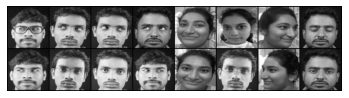

[[0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]]


In [10]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

## Neural Net Definition


In [11]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500), #y = x*W^T + b 
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),
      
            nn.Linear(500, 128)) # 5 features, 128 features

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1) # flattening .. connect to fully connected layer
        output = self.fc1(output)
        return output

    def forward(self, input1, input2): # invoked automatically when you pass an image to object
        output1 = self.forward_once(input1)
        #capture those 128 features of image1
        output2 = self.forward_once(input2)
        #capture those 128 featues of image2
        return output1, output2

###Contrastive Loss
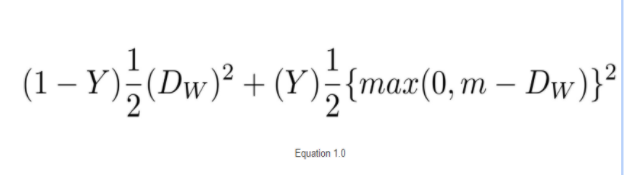

In [12]:
class ContrastiveLoss(torch.nn.Module):

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                     (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)) 


        return loss_contrastive

## Training Time!

In [13]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

In [14]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

Graph of the Network Architechture

In [15]:
pip install torchviz

     |████████████████████████████████| 51kB 4.8MB/s 
  Created wheel for torchviz: filename=torchviz-0.0.1-cp36-none-any.whl size=3522 sha256=29ae22e82ea2db4130ab5023c7cafd1722727428e1de1bc141ff7c3999e09f79
  Stored in directory: /root/.cache/pip/wheels/2a/c2/c5/b8b4d0f7992c735f6db5bfa3c5f354cf36502037ca2b585667
Successfully built torchviz


In [16]:
batch = next(iter(train_dataloader))
yhat = net(batch[0].cuda(), batch[1].cuda())

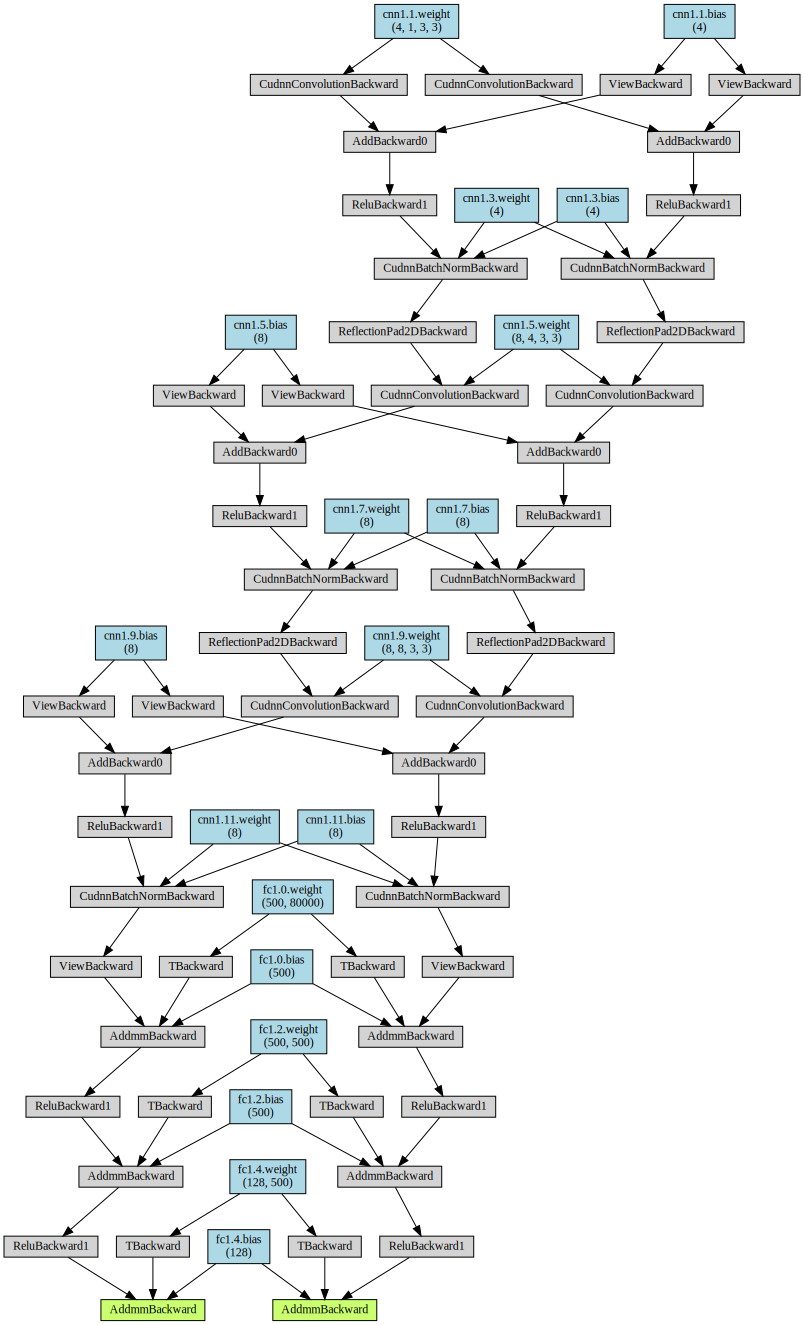

In [17]:
from torchviz import make_dot, make_dot_from_trace
make_dot(net(batch[0].cuda(), batch[1].cuda()), params=dict(net.named_parameters()))

Epoch number 0
 Current loss 0.8731665015220642

Epoch number 1
 Current loss 34.767391204833984

Epoch number 2
 Current loss 12.600598335266113

Epoch number 3
 Current loss 14.449737548828125

Epoch number 4
 Current loss 7.192371368408203

Epoch number 5
 Current loss 7.645317077636719

Epoch number 6
 Current loss 22.564353942871094

Epoch number 7
 Current loss 2.9738616943359375

Epoch number 8
 Current loss 4.5975799560546875

Epoch number 9
 Current loss 5.560202598571777

Epoch number 10
 Current loss 2.055356740951538

Epoch number 11
 Current loss 1.1542335748672485

Epoch number 12
 Current loss 1.011922836303711

Epoch number 13
 Current loss 0.7585455179214478

Epoch number 14
 Current loss 0.7215628623962402

Epoch number 15
 Current loss 1.0612561702728271

Epoch number 16
 Current loss 0.4978284239768982

Epoch number 17
 Current loss 1.0257492065429688

Epoch number 18
 Current loss 0.2529255151748657

Epoch number 19
 Current loss 0.4006783962249756

Epoch number 20

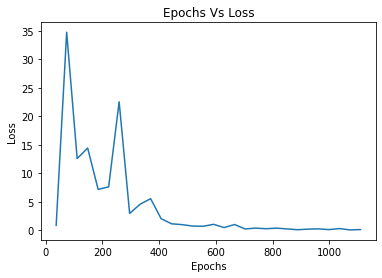

In [18]:
output = [] 
counter = []
loss_history = [] 
iteration_number= 0
paths = []
for epoch in range(0,Config.train_number_epochs):

    for i, data in enumerate(train_dataloader,0): 
      #add a path vraiabale inorder to fetch the path aslo
        img0, img1 , label, path1,path2 = data
        img0, img1 , label, path1,path2 = img0.cuda(), img1.cuda() , label.cuda(), path1,path2
      
        optimizer.zero_grad()  #Clears the previous gradients for every batch
        output1, output2 = net(img0, img1)
 
        if(epoch == (Config.train_number_epochs-1)):
          output.append(output1)
          paths.append(path1)
          output.append(output2)
          paths.append(path2)
        loss_contrastive = criterion(output1,output2,label) #criteria here is contrastive loss
        #Gradient Descent - Updating weights
        loss_contrastive.backward()
        optimizer.step()
        
        if i %37 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=37
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item()) #Extracts the loss as a python float from tensor
            
show_plot(counter,loss_history)

In [19]:
len(output)

6

In [20]:
import pandas as pd
df1 = pd.DataFrame(output[0].cpu().data.numpy())
df1['Paths'] = np.asarray(paths[0][0])
for i in range(1,len(output)):
  df2 = pd.DataFrame(output[i].cpu().data.numpy())
  df2['Paths'] = np.asarray(paths[i][0])
  df1=pd.concat([df1,df2],ignore_index=True,axis=0)

## Some simple testing
The last 3 subjects were held out from the training, and will be used to test. The Distance between each image pair denotes the degree of similarity the model found between the two images. Less means it found more similar, while higher values indicate it found them to be dissimilar.

In [21]:

list1 = []
paths = []
for j in range(6):
  folder_dataset_test = dset.ImageFolder(root=Config.validation_dir)
  siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

  test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=True)
  dataiter = iter(test_dataloader)
  x0,_,_,_,_ = next(dataiter)
  for i in range(10):
      _,x1,label2,path1,path2 = next(dataiter)
      concatenated = torch.cat((x0,x1),0)
    
      output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
      list1.append(output2)
      paths.append(path2)
      euclidean_distance = F.pairwise_distance(output1, output2)
  #imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))



In [22]:
paths_1 = []
for i in range(len(paths)):
  paths_1.append(paths[i][0][0])
paths_1 = np.array(paths_1).reshape(1,-1)

In [23]:
list2 = []
for i in range(60):
  list2.append(list1[i].cpu().data.numpy())

In [24]:
df0 = pd.DataFrame(list2[0])

In [25]:
len(paths_1[0])

60

In [26]:
for i in range(1,60):
  df0 = df0.append(pd.DataFrame(list2[i].reshape(1,-1), columns=list(df0)), ignore_index=True)
df0['Paths'] = paths_1[0]
df2 = pd.concat([df2,df0], ignore_index=True, axis = 0)
df=pd.concat([df1,df2])

In [27]:
df=df.drop_duplicates('Paths')

In [28]:

df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,Paths
0,0.608988,-0.388075,-0.068696,-0.020806,-0.096305,0.805366,0.063446,0.035345,0.039321,-0.206429,-0.764174,0.028252,0.267980,-0.453226,-0.024394,-0.063291,-0.213161,0.340977,-0.137572,0.251350,0.011730,-0.761072,0.454061,1.123998,-0.230218,0.126405,-0.051104,-0.017939,0.517267,-0.384734,-0.434228,-0.120648,-0.384592,0.166341,-0.180388,0.400365,-0.558596,-0.105375,0.056736,0.163427,...,0.259195,0.169585,-0.180202,0.226335,-0.830774,0.475394,-0.167106,0.490391,-0.049352,-0.068420,0.062002,-0.441880,0.053677,0.550583,0.116917,-0.551078,0.346829,0.025676,0.192225,0.513429,0.075064,0.250620,0.458421,0.099458,-0.736041,-0.108722,0.284625,-0.145165,-0.283901,0.550505,-0.128932,-0.426709,0.210385,-0.200854,0.510811,-0.414314,0.047552,-0.493930,0.388468,/content/drive/MyDrive/SiameseNetwork_Project/...
1,0.073961,-0.519904,0.388420,0.645132,-0.583875,0.687450,-0.106881,-0.069877,0.018885,-0.126400,-0.264626,-0.103817,0.018815,0.199979,0.255924,0.897356,-0.423742,-0.395507,-0.861538,-0.505818,-0.288810,-0.029184,-0.595863,0.286258,-0.227428,-0.489156,-0.175481,-0.364865,0.056310,-0.188219,0.154829,0.107502,0.423282,-0.095322,-0.092807,0.277708,0.722051,0.980391,0.115961,-0.138445,...,-0.781709,0.049043,0.139216,-0.201827,-0.225414,0.225463,-0.292868,-0.592913,0.091970,0.446710,-0.354342,0.320823,0.409160,0.905606,-0.388100,0.087308,0.574264,-0.307522,0.059141,0.407023,-0.210303,-0.911855,0.601103,-0.266925,0.039284,-0.343961,-0.823639,-0.875308,-0.247018,-0.188897,0.187679,0.015071,0.026055,-0.050050,0.301872,-0.487687,-0.279463,-0.883181,0.104541,/content/drive/MyDrive/SiameseNetwork_Project/...
2,0.573623,-0.351806,0.001428,-0.283757,-0.027567,0.667285,-0.076403,-0.189690,0.216323,-0.046153,-0.648776,-0.031275,0.167153,-0.337308,-0.121808,-0.145341,-0.247508,0.379269,-0.042387,0.311437,0.158396,-0.439771,0.265845,0.813558,-0.208964,-0.257127,0.166013,0.226003,0.312663,-0.528318,-0.412580,-0.221226,-0.227151,-0.075534,0.117611,0.102438,-0.486393,0.053744,0.188208,0.375181,...,0.309638,-0.148235,0.008584,0.181645,-0.706416,0.436680,-0.222048,0.390984,-0.343399,0.027694,-0.009145,-0.303144,0.184066,0.394778,0.228388,-0.363095,0.596998,0.133397,-0.090374,0.272280,-0.056799,0.434426,0.471651,0.224435,-0.559123,-0.044218,0.046142,-0.253102,-0.100763,0.256554,0.125834,-0.554466,-0.032593,-0.223452,0.466041,-0.185342,0.184894,-0.303877,0.499469,/content/drive/MyDrive/SiameseNetwork_Project/...
3,0.647714,-0.268741,0.045322,-0.440285,-0.128528,0.778490,-0.089575,-0.272777,0.382415,0.181678,-0.975025,0.091772,0.378830,-0.056995,-0.062837,0.183218,-0.591344,0.766648,-0.066898,0.489833,0.163500,-0.649154,0.443355,0.782223,-0.433584,-0.346257,0.357354,0.192093,0.177654,-0.761009,-0.571325,-0.377786,-0.364811,-0.158264,0.392963,-0.046970,-0.512328,0.074434,0.167157,0.671539,...,0.458532,-0.337661,-0.004267,0.241826,-0.906310,0.687607,-0.193117,0.532907,-0.099604,-0.013397,0.244817,-0.546676,0.439478,0.818899,0.210279,-0.258037,0.571899,0.201219,-0.167534,0.379647,-0.104775,0.332881,0.706131,0.245208,-0.723527,-0.251841,-0.224119,-0.488356,-0.217926,0.223625,0.094354,-0.758995,0.224206,-0.100768,0.772996,-0.293275,0.245328,-0.415237,0.650207,/content/drive/MyDrive/SiameseNetwork_Project/...
4,-0.013382,-0.100450,-0.229279,-0.136736,-0.274974,0.003259,0.024287,0.026160,0.068377,0.171931,-0.108154,0.231075,-0.207543,-0.147939,-0.334998,0.221530,-0.333803,-0.301187,0.322690,0.585925,-0.013980,0.086595,0.053615,0.153594,-0.129079,0.136620,0.008165,-0.168224,0.179954,-0.153430,-0.128298,-0.075400,-0.301331,0.028502,0.217459,0.424985,0.156962,0.321717,-0.003646,0.079202,...,0.160644,-0.117064,-0.103486,-0.377621,0.114668,0.525376,0.343774,-0.279574,0.044490,0.004169,0.207386,-0.175744,0.463484,

In [29]:
df.to_csv("cluster.csv", index=False)

In [30]:
df = pd.read_csv("cluster.csv")

In [31]:
X = df.iloc[:, :-1].values
X.shape

(189, 128)

In [32]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 15, init = 'k-means++', random_state = 42)
kmeans.fit(X)
y_kmeans =  kmeans.fit_predict(X)

In [33]:
import pickle
pkl_filename = "pickle_model.pkl"
with open(pkl_filename, 'wb') as file:
      pickle.dump(kmeans, file)

In [34]:
y_kmeans = pd.Series(y_kmeans)

In [35]:
df['Class'] = y_kmeans

In [36]:
df.to_csv("labels.csv", index = False)

In [37]:
torch.save(net.state_dict(), "model.pth")

In [38]:
  for j in df[df.Class == 4]['Paths']:
    print(j)

/content/drive/MyDrive/SiameseNetwork_Project/Training/S1/S1_9.jpg
/content/drive/MyDrive/SiameseNetwork_Project/Training/S1/S1_3.jpg
/content/drive/MyDrive/SiameseNetwork_Project/Training/S1/S1_7.jpg
/content/drive/MyDrive/SiameseNetwork_Project/Training/S1/S1_15.jpg
/content/drive/MyDrive/SiameseNetwork_Project/Training/S1/S1_8.jpg
/content/drive/MyDrive/SiameseNetwork_Project/Training/S1/S1_2.jpg
/content/drive/MyDrive/SiameseNetwork_Project/Training/S1/S1_4.jpg
/content/drive/MyDrive/SiameseNetwork_Project/Training/S1/S1_1.jpg
/content/drive/MyDrive/SiameseNetwork_Project/Training/S1/S1_14.jpg
/content/drive/MyDrive/SiameseNetwork_Project/Training/S1/S1_13.jpg
/content/drive/MyDrive/SiameseNetwork_Project/Training/S1/S1_11.jpg
/content/drive/MyDrive/SiameseNetwork_Project/Training/S1/S1_10.jpg
/content/drive/MyDrive/SiameseNetwork_Project/Training/S1/S1_12.jpg
/content/drive/MyDrive/SiameseNetwork_Project/Training/S1/S1_5.jpg
/content/drive/MyDrive/SiameseNetwork_Project/Training/S

In [39]:
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,Paths,Class
0,0.608988,-0.388075,-0.068696,-0.020806,-0.096305,0.805366,0.063446,0.035345,0.039321,-0.206429,-0.764174,0.028252,0.267980,-0.453226,-0.024394,-0.063291,-0.213161,0.340977,-0.137572,0.251350,0.011730,-0.761072,0.454061,1.123998,-0.230218,0.126405,-0.051104,-0.017939,0.517267,-0.384734,-0.434228,-0.120648,-0.384592,0.166341,-0.180388,0.400365,-0.558596,-0.105375,0.056737,0.163427,...,0.169585,-0.180202,0.226335,-0.830774,0.475394,-0.167106,0.490391,-0.049352,-0.068420,0.062002,-0.441880,0.053677,0.550583,0.116917,-0.551078,0.346829,0.025676,0.192225,0.513429,0.075064,0.250620,0.458421,0.099458,-0.736041,-0.108722,0.284625,-0.145165,-0.283901,0.550505,-0.128932,-0.426709,0.210385,-0.200854,0.510811,-0.414314,0.047552,-0.493930,0.388468,/content/drive/MyDrive/SiameseNetwork_Project/...,10
1,0.073961,-0.519904,0.388420,0.645132,-0.583875,0.687450,-0.106881,-0.069877,0.018885,-0.126399,-0.264626,-0.103817,0.018815,0.199979,0.255924,0.897356,-0.423742,-0.395507,-0.861538,-0.505819,-0.288810,-0.029184,-0.595863,0.286258,-0.227428,-0.489156,-0.175481,-0.364865,0.056310,-0.188219,0.154829,0.107502,0.423282,-0.095322,-0.092807,0.277708,0.722051,0.980391,0.115961,-0.138445,...,0.049043,0.139216,-0.201827,-0.225414,0.225463,-0.292868,-0.592913,0.091970,0.446710,-0.354342,0.320823,0.409160,0.905606,-0.388100,0.087308,0.574264,-0.307522,0.059141,0.407023,-0.210303,-0.911855,0.601103,-0.266925,0.039284,-0.343961,-0.823639,-0.875308,-0.247018,-0.188897,0.187679,0.015071,0.026055,-0.050050,0.301872,-0.487686,-0.279463,-0.883181,0.104541,/content/drive/MyDrive/SiameseNetwork_Project/...,3
2,0.573623,-0.351806,0.001428,-0.283757,-0.027567,0.667285,-0.076403,-0.189690,0.216323,-0.046153,-0.648776,-0.031275,0.167153,-0.337308,-0.121808,-0.145341,-0.247508,0.379269,-0.042387,0.311437,0.158396,-0.439771,0.265845,0.813558,-0.208964,-0.257127,0.166013,0.226003,0.312663,-0.528317,-0.412580,-0.221226,-0.227151,-0.075534,0.117611,0.102438,-0.486393,0.053744,0.188208,0.375181,...,-0.148235,0.008584,0.181645,-0.706416,0.436680,-0.222048,0.390984,-0.343399,0.027694,-0.009145,-0.303144,0.184066,0.394778,0.228388,-0.363095,0.596998,0.133397,-0.090374,0.272280,-0.056799,0.434426,0.471651,0.224435,-0.559123,-0.044218,0.046142,-0.253102,-0.100763,0.256554,0.125834,-0.554466,-0.032593,-0.223452,0.466041,-0.185342,0.184894,-0.303877,0.499469,/content/drive/MyDrive/SiameseNetwork_Project/...,8
3,0.647714,-0.268741,0.045322,-0.440285,-0.128528,0.778490,-0.089575,-0.272777,0.382415,0.181678,-0.975025,0.091772,0.378830,-0.056995,-0.062837,0.183218,-0.591344,0.766648,-0.066898,0.489833,0.163500,-0.649154,0.443355,0.782223,-0.433584,-0.346257,0.357354,0.192093,0.177654,-0.761009,-0.571325,-0.377786,-0.364811,-0.158264,0.392963,-0.046970,-0.512328,0.074434,0.167157,0.671539,...,-0.337661,-0.004267,0.241826,-0.906310,0.687607,-0.193117,0.532907,-0.099604,-0.013397,0.244817,-0.546676,0.439478,0.818899,0.210279,-0.258037,0.571899,0.201219,-0.167534,0.379647,-0.104775,0.332881,0.706131,0.245208,-0.723527,-0.251841,-0.224119,-0.488356,-0.217926,0.223625,0.094354,-0.758995,0.224206,-0.100768,0.772996,-0.293275,0.245328,-0.415237,0.650207,/content/drive/MyDrive/SiameseNetwork_Project/...,4
4,-0.013382,-0.100450,-0.229279,-0.136736,-0.274974,0.003259,0.024287,0.026160,0.068377,0.171931,-0.108154,0.231075,-0.207543,-0.147939,-0.334998,0.221530,-0.333803,-0.301187,0.322690,0.585925,-0.013980,0.086595,0.053615,0.153594,-0.129079,0.136620,0.008165,-0.168224,0.179954,-0.153430,-0.128298,-0.075400,-0.301331,0.028502,0.217459,0.424985,0.156962,0.321717,-0.003646,0.079202,...,-0.117064,-0.103486,-0.377621,0.114668,0.525376,0.343774,-0.279574,0.044490,0.004169,0.207386,-0.175744,0.463484,0.579342,-0.043278,-0.359393,0.142